In [1]:
# Config & imports

import os, glob, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

# --- Paths ---
pure_train_folder = "../data/refs/ptfe_1000"    # pure PTFE base spectra
map_folder        = "../data/test/spot2"            # measured spectra to predict
profile_path      = "../data/test/profile/profile2.CSV"  # XY positions (001..N)
out_dir           = "../results"
plot_dir          = "../plots"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# --- Parallel ---
MAX_WORKERS = min(32, os.cpu_count() or 8)

# --- Spectral features & preprocessing ---
BANDS       = None           # e.g. [(1800, 800)] to restrict to fingerprint region
DOWNSAMPLE  = None           # e.g. 2 to keep every 2nd point
USE_SGDER   = False          # Savitzky–Golay derivative (reduces baseline effects)
USE_SNV     = True           # Standard Normal Variate normalization
SG_WIN, SG_POLY = 15, 2

# --- PCA & (fallback) fixed thresholds ---
VAR_TARGET     = 0.999
MAX_COMPONENTS = 1000
Q_THRESH_PERC  = 99.5
T2_THRESH_PERC = 99.5

# --- Scoring choice ---
# Robust default: use Q only (set False). If True, uses zQ+zT² combo (more sensitive).
COMBINE_Q_T2   = False

# --- Auto-calibration sensitivity (for threshold scaling) ---
# "strict" (few FPs, risk FNs), "balanced" (default), "lenient" (fewer FNs)
SENSITIVITY = "lenient"

print("Config OK → outputs:", out_dir)


Config OK → outputs: ../results


In [2]:
# Loaders & helpers

def load_xy_header_aware(fn):
    """Read 2-col CSV (wavenumber, absorbance); header-safe; sorts by wavenumber."""
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]
    order = np.argsort(wn)
    return wn[order], ab[order]

def strict_indexed_list(folder, N):
    """Return files in exact *_001.CSV .. *_NNN.CSV order (required)."""
    files = []
    for idx in range(1, N+1):
        hit = glob.glob(os.path.join(folder, f"*_80{idx:03d}.CSV"))
        if not hit:
            raise FileNotFoundError(f"Missing spectrum for index {idx:03d} in {folder}")
        files.append(hit[0])
    return files

def band_mask(wn, bands):
    if not bands: return np.ones_like(wn, dtype=bool)
    m = np.zeros_like(wn, dtype=bool)
    for lo, hi in bands:
        lo, hi = min(lo,hi), max(lo,hi)
        m |= (wn >= lo) & (wn <= hi)
    return m

def concat_bands(wn, y, bands, ds=None):
    wn_ref, y_ref = (wn[::ds], y[::ds]) if (ds and ds>1) else (wn, y)
    m = band_mask(wn_ref, bands)
    return wn_ref[m], y_ref[m]

def snv(A):
    mu = A.mean(axis=1, keepdims=True)
    sd = A.std(axis=1, keepdims=True) + 1e-12
    return (A - mu) / sd

def sg_derivative(A, win=15, poly=2, dx=1.0):
    return savgol_filter(A, window_length=win, polyorder=poly, deriv=1,
                         delta=dx, axis=1)


In [3]:
# Build PCA from pure PTFE

pure_files = sorted(glob.glob(os.path.join(pure_train_folder, "*.CSV")))
assert len(pure_files) > 0, f"No pure files found in {pure_train_folder}"

wn0, _ = load_xy_header_aware(pure_files[0])

def interp_and_band(fn, wn_ref, bands, ds):
    wn_i, y_i = load_xy_header_aware(fn)
    y_interp = np.interp(wn_ref, wn_i, y_i)
    wn_sel, y_sel = concat_bands(wn_ref, y_interp, bands, ds)
    return wn_sel, y_sel

t0 = time.time()
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(interp_and_band, f, wn0, BANDS, DOWNSAMPLE): i
            for i, f in enumerate(pure_files)}
    outs = [None]*len(pure_files)
    for fut in as_completed(futs):
        outs[futs[fut]] = fut.result()

wn_sel = outs[0][0]
X_pure = np.vstack([o[1] for o in outs])

# Preprocess
Xtr = X_pure.copy()
if USE_SGDER: Xtr = sg_derivative(Xtr, win=SG_WIN, poly=SG_POLY, dx=1.0)
if USE_SNV:   Xtr = snv(Xtr)

print(f"Pure PTFE matrix: {X_pure.shape}  built in {time.time()-t0:.2f}s")


Pure PTFE matrix: (1000, 1724)  built in 0.73s


In [4]:
# Train PCA & compute thresholds

pca_full = PCA(n_components=min(MAX_COMPONENTS, Xtr.shape[1]),
               svd_solver="full", random_state=0)
pca_full.fit(Xtr)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)
k = int(np.searchsorted(cumvar, VAR_TARGET) + 1)
k = min(k, MAX_COMPONENTS)

pca = PCA(n_components=k, svd_solver="full", random_state=0)
T = pca.fit_transform(Xtr)
Xtr_hat = pca.inverse_transform(T)
E = Xtr - Xtr_hat
Q_train = np.sum(E**2, axis=1)
lam = pca.explained_variance_
T2_train = np.sum((T**2)/(lam+1e-15), axis=1)

Q_thresh  = np.percentile(Q_train,  Q_THRESH_PERC)
T2_thresh = np.percentile(T2_train, T2_THRESH_PERC)

print(f"PCA k={k}, cum.var={cumvar[k-1]:.4f}")
print(f"Fixed training thresholds → Q@{Q_THRESH_PERC}%={Q_thresh:.3g}, T²@{T2_THRESH_PERC}%={T2_thresh:.3g}")


PCA k=60, cum.var=0.9990
Fixed training thresholds → Q@99.5%=0.0122, T²@99.5%=217


In [5]:
# Cell 4 — Load map (001..N), preprocess & score
# XY order from profile

prof = pd.read_csv(profile_path, header=None)
prof.columns = ["X","Y","_"]
N = len(prof)

map_files = strict_indexed_list(map_folder, N)

def map_row(fn, wn_ref, bands, ds):
    wn_i, y_i = load_xy_header_aware(fn)
    yi = np.interp(wn_ref, wn_i, y_i)
    _, y_sel = concat_bands(wn_ref, yi, bands, ds)
    return y_sel

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(map_row, f, wn0, BANDS, DOWNSAMPLE): i for i, f in enumerate(map_files)}
    rows = [None]*len(map_files)
    for fut in as_completed(futs):
        rows[futs[fut]] = fut.result()

X_map = np.vstack(rows)

# Same preprocessing as training
Xmp = X_map.copy()
if USE_SGDER: Xmp = sg_derivative(Xmp, win=SG_WIN, poly=SG_POLY, dx=1.0)
if USE_SNV:   Xmp = snv(Xmp)

# Project & compute statistics
T_map = pca.transform(Xmp)
Xmp_hat = pca.inverse_transform(T_map)
E_map = Xmp - Xmp_hat
Q_map = np.sum(E_map**2, axis=1)
T2_map = np.sum((T_map**2)/(lam+1e-15), axis=1)

# Continuous score (robust default: Q only)
if COMBINE_Q_T2:
    zQ  = (Q_map  - Q_train.mean()) / (Q_train.std()  + 1e-12)
    zT2 = (T2_map - T2_train.mean()) / (T2_train.std() + 1e-12)
    score_map   = zQ + zT2
    score_train = ((Q_train - Q_train.mean())/(Q_train.std()+1e-12)
                   + (T2_train - T2_train.mean())/(T2_train.std()+1e-12))
else:
    score_map   = Q_map
    score_train = Q_train


In [6]:
# Auto-calibrated threshold & predict
# Assumption: majority of pixels are pure → medians reflect "normal".
# We lift the training threshold by median(map)/median(train) and a sensitivity multiplier.

# Base threshold from training distribution:
base_thr = (np.percentile(score_train, 99.5)
            if COMBINE_Q_T2 else Q_thresh)

# Scale by median ratio (map baseline drift vs training)
scale = (np.median(score_map) / (np.median(score_train) + 1e-12))
# Sensitivity multiplier
mult = {"strict": 1.00, "balanced": 1.20, "lenient": 2.00}[SENSITIVITY]

THR_AUTO = base_thr * max(1.0, scale) * mult

print(f"[Auto-cal] base_thr={base_thr:.3g}  scale={scale:.3f}  mult={mult:.2f}  →  THR_AUTO={THR_AUTO:.3g}")

# Predict (binary)
pred_impurity = (score_map > THR_AUTO).astype(int)

pred_df = pd.DataFrame({
    "index": np.arange(1, N+1),
    "X": prof["X"], "Y": prof["Y"],
    "Q_residual": Q_map, "T2": T2_map,
    "score": score_map,
    "pred_impurity": pred_impurity
})
pred_path = os.path.join(out_dir, "test_pca_spot1.csv")
pred_df.to_csv(pred_path, index=False)
print("Saved:", pred_path)


[Auto-cal] base_thr=0.0122  scale=71.140  mult=2.00  →  THR_AUTO=1.74
Saved: ../results/test_pca_spot1.csv


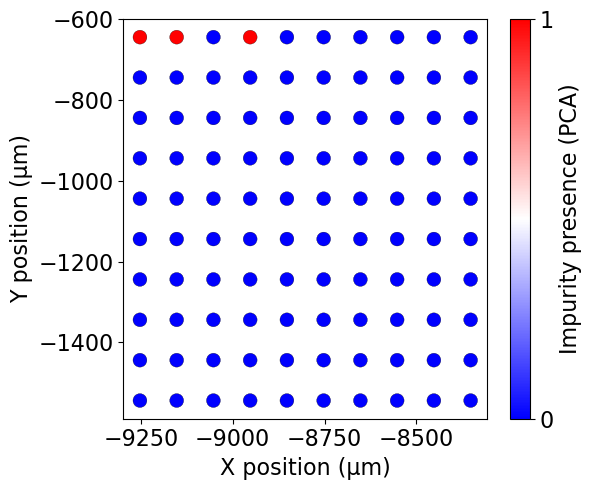

Saved: ../plots/fig5j.jpg


In [7]:
# Binary impurity map 

plt.figure(figsize=(6, 5))

# Scatter with class values for a discrete colorbar (0=pure, 1=impure)
sc = plt.scatter(
    pred_df["X"], pred_df["Y"],
    c=pred_df["pred_impurity"],   # 0/1 labels
    cmap="bwr",                   # red/blue colormap for binary classes
    s=100,
    edgecolor="k",
    linewidth=0.2
)

# Colorbar
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label("Impurity presence (PCA)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Axes
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# Tick intervals (~5 per axis)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
path_bin = os.path.join(plot_dir, "fig5j.jpg")
plt.savefig(path_bin, dpi=500)
plt.show()
print("Saved:", path_bin)
